#Setup

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras import metrics
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os, sys
# os.chdir("//content/drive/my-drive/AOI") #這邊輸入欲使用的資料夾路徑
os.chdir("/content/gdrive/MyDrive")
os.getcwd()

'/content/gdrive/MyDrive'

#Reading files(1st time)

In [ ]:
with open("train.txt", "r") as f:
  lines = [line.rstrip() for line in f]

files, labels = [], []

for line in lines:
  s = line.split(" ")
  files.append(s[0])
  labels.append(int(s[1]))

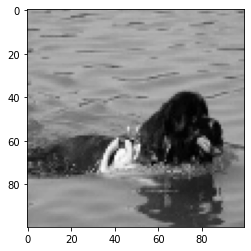

In [ ]:
#Check the sample of image
img = cv.imread(files[0],0)
img = cv.resize(img, (100, 100))
plt.imshow(img, cmap = plt.cm.gray)
plt.show()

In [ ]:
#Reading file names and adding into array
images = []
i = 0
for file in files:
  img = cv.imread(file, 0)
  img = np.array(cv.resize(img, (80, 80)))

  images.append(img)
  if (i%200)==0:
    print(i)
  i = i + 1

images = np.array(images)

In [ ]:
#Save the whole set of image data into .npy
#This step is done to train, valid, and test(only showed train set here)
with open("train_file.npy", "wb") as f:
  np.save(f, images)

In [ ]:
#reading the .npy files to load the arrays
with open("train_file.npy", "rb") as f:
  train = np.load(f)

with open("valid_file.npy", "rb") as f:
  valid = np.load(f)

with open("test_file.npy", "rb") as f:
  test = np.load(f)



In [ ]:
#Reading for the labels
train_labels, valid_labels, test_labels = [], [], []

with open("train.txt", "r") as f:
  lines = [line.rstrip() for line in f]

for line in lines:
  s = line.split(" ")
  train_labels.append(int(s[1]))

with open("test.txt", "r") as f:
  lines = [line.rstrip() for line in f]

for line in lines:
  s = line.split(" ")
  test_labels.append(int(s[1]))

with open("val.txt", "r") as f:
  lines = [line.rstrip() for line in f]

for line in lines:
  s = line.split(" ")
  valid_labels.append(int(s[1]))

# CNN Method

In [ ]:
network = models.Sequential()
network.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = (80, 80, 1)))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Dropout(0.4))
network.add(layers.Flatten())
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(50, activation='softmax'))

#for top-5accuracy
def top_acc_5(y_true, y_pred):
  return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

network.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy', top_acc_5]
)


network.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [ ]:
#All image are reshaped to 80*80 grayscale
images_cnn = train.reshape((63325, 80, 80, 1))
images_cnn = images_cnn.astype("float32")/255
images_cnn.shape

label_cnn = to_categorical(labels)

In [ ]:
#This is an object that can make the cnn model stop earlier if validation acc don't increase for several epochs
checkpointer = ModelCheckpoint(filepath='/content/gdrive/MyDrive/weights.best.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
#Saving the parameters so I don't have to train from the very beginning if I paused the training process
network.load_weights('saved_models/weights.best.hdf5')

In [ ]:
history = network.fit(images_cnn, label_cnn,
          #batch_size=512,
          epochs=10,
          verbose=1,
          validation_split=0.2,
          callbacks=checkpointer)

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'top_acc_5', 'val_loss', 'val_accuracy', 'val_top_acc_5'])


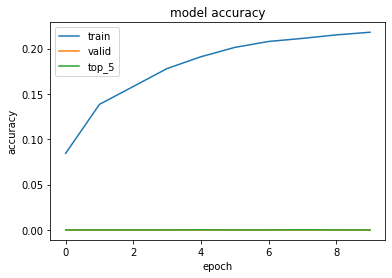

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_top_acc_5'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid', 'top_5'], loc='upper left')
plt.show()

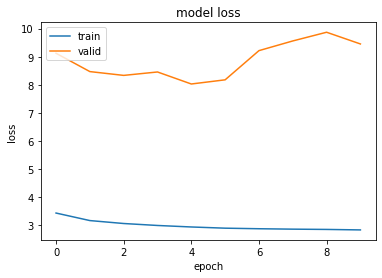

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
test_cnn = test.reshape((450, 80, 80, 1))
test_cnn = test_cnn.astype("float32")/255

test_labels_cnn = to_categorical(test_labels)

test_loss, test_acc, top_5_acc_test = network.evaluate(test_cnn, test_labels_cnn)
print(test_acc)
print(top_5_acc_test)

15/15 [==============================] - 1s 51ms/step - loss: 4.3340 - accuracy: 0.1511 - top_acc_5: 0.3844
0.15111111104488373
0.3844444453716278


In [ ]:
valid_cnn = valid.reshape((450, 80, 80, 1))
valid_cnn = valid_cnn.astype("float32")/255

valid_labels_cnn = to_categorical(valid_labels)

valid_loss, valid_acc, top_5_acc_valid = network.evaluate(valid_cnn, valid_labels_cnn)
print(valid_acc)
print(top_5_acc_valid)

15/15 [==============================] - 2s 147ms/step - loss: 4.2817 - accuracy: 0.1400 - top_acc_5: 0.3978
0.14000000059604645
0.3977777659893036


#MLP Method

In [ ]:
#Flatten the images to 1-dim array
X_train = train.reshape((63325, 6400))
X_train = X_train.astype("float32")/255

#Convert labels to arrays like one-hot encoding
y_train = np.array(train_labels)
y_train = to_categorical(y_train)

In [ ]:
X_train

array([[0.627451  , 0.627451  , 0.6313726 , ..., 0.49803922, 0.47058824,
        0.46666667],
       [0.9647059 , 0.9490196 , 0.8392157 , ..., 0.56078434, 0.5176471 ,
        0.50980395],
       [0.9647059 , 0.9764706 , 0.9843137 , ..., 0.05098039, 0.05490196,
        0.05490196],
       ...,
       [0.59607846, 0.5529412 , 0.54509807, ..., 0.5803922 , 0.48235294,
        0.47058824],
       [0.5686275 , 0.4862745 , 0.3647059 , ..., 0.37254903, 0.29803923,
        0.09019608],
       [0.39607844, 0.22745098, 0.19215687, ..., 0.4392157 , 0.49411765,
        0.50980395]], dtype=float32)

In [ ]:
#To avoid training for too long, picked PCA
model = Pipeline(steps = [
    ('pca', PCA(n_components= 1000, random_state= 13)),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=[300, 200],
        #activation='relu',
        random_state=13))
])

model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=1000, random_state=13)),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=[300, 200], random_state=13))])

In [ ]:
X_test = test.reshape((450, 6400))
X_test = X_test.astype("float32")/255

y_test = np.array(test_labels)

test_pred = model.predict(X_test)
test_pred_max = np.argmax(test_pred, axis = 1)

print(accuracy_score(y_test, test_pred_max))


y_test = to_categorical(y_test)
x = top_acc_5(y_test, test_pred)
print(np.sum(x)/len(x))

0.024444444444444446
0.14444444444444443


In [ ]:
X_valid = valid.reshape((450, 6400))
X_valid = X_valid.astype("float32")/255

y_valid = np.array(valid_labels)

valid_pred = model.predict(X_valid)
valid_pred_max = np.argmax(valid_pred, axis = 1)

print(accuracy_score(y_valid, valid_pred_max))


y_valid = to_categorical(y_valid)
x = top_acc_5(y_valid, valid_pred)
print(np.sum(x)/len(x))

0.057777777777777775
0.20444444444444446


#XGB Method

In [ ]:
model = Pipeline(steps = [
    ('pca', PCA(n_components= 1000, random_state= 13)),
    ('xgb', XGBRegressor(
        max_depth = 4,
        n_estimators=50,
        tree_method = "hist",
        random_state=13)
    )
])


model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=1000, random_state=13)),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=50,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=13, ...))])

In [ ]:
X_test = test.reshape((450, 6400))
X_test = X_test.astype("float32")/255

y_test = np.array(test_labels)

test_pred = model.predict(X_test)
test_pred_max = np.argmax(test_pred, axis = 1)

print(accuracy_score(y_test, test_pred_max))


y_test = to_categorical(y_test)
x = top_acc_5(y_test, test_pred)
print(np.sum(x)/len(x))

0.09111111111111111
0.26666666666666666


In [ ]:
X_valid = valid.reshape((450, 6400))
X_valid = X_valid.astype("float32")/255

y_valid = np.array(valid_labels)

valid_pred = model.predict(X_valid)
valid_pred_max = np.argmax(valid_pred, axis = 1)

print(accuracy_score(y_valid, valid_pred_max))


y_valid = to_categorical(y_valid)
x = top_acc_5(y_valid, valid_pred)
print(np.sum(x)/len(x))

0.10222222222222223
0.27555555555555555
